## Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [ ]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *

In [ ]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [ ]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
NUM_CORES = 16

In [5]:
LEVEL_DOC = 0
LEVEL_DIVISIONS = 1
LEVEL_CHUNKS = 2

PARTS_LEVEL = LEVEL_CHUNKS

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"

In [8]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [9]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

doc_vec_types = "extended_abs_desc_claims_all_levels_3"
doc_vec_preprocessed_data_types = "extended_pv_abs_desc_claims_all_levels_3"

exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(big_data_location, "parameter_search_doc2vec_models_" + doc_vec_types, "full")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_" + doc_vec_types)
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output.json'

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list.pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list.pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list.pkl"

preprocessed_location = os.path.join(big_data_location, "preprocessed_data", doc_vec_preprocessed_data_types) + "/"

training_preprocessed_files_prefix = preprocessed_location + "extended_pv_training_docs_data_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "extended_pv_validation_docs_data_preprocessed-"
test_preprocessed_files_prefix = preprocessed_location + "extended_pv_test_docs_data_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 16 s, sys: 1.11 s, total: 17.1 s
Wall time: 17.1 s


In [11]:
len(training_docs_list)

120156

In [12]:
len(validation_docs_list)

29675

In [13]:
len(test_docs_list)

37771

In [14]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [15]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector


## Get Document, Paragraph and Sentence Stats

In [16]:
class FixedDocumentsStatsGenerator(object):
    def __init__(self, filename_prefix):
        self.filename_prefix = filename_prefix
        self.docids = []
        self.doc_parts = defaultdict(list)
        self.doc_part_chunks = defaultdict(list)
        self.curr_doc_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        info("Loading new batch for index: {}".format(self.curr_doc_index))
        true_docs_count = 0
        try:
            with open(self.filename_prefix + str(self.curr_doc_index)) as preproc_file:
                for line in preproc_file:
                    line_array = line.split(" ", 1)
                    entity_id = line_array[0].strip()
                    if self.is_doc(entity_id):
                        self.docids.append(entity_id)
                        true_docs_count+= 1
                    elif self.is_doc_part(entity_id):
                        self.doc_parts[self.get_doc_id(entity_id)].append(entity_id)
                    elif self.is_doc_part_chunk(entity_id):
                        self.doc_part_chunks[self.get_doc_id(entity_id)].append(entity_id)
            self.batch_end = self.curr_doc_index + true_docs_count - 1 
            info("Finished loading new batch of {} documents".format(true_docs_count))
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_doc_index))
            raise StopIteration()
    def get_stats(self):
        try:
            while True:
                if self.curr_doc_index > self.batch_end:
                    self.load_new_batch_in_memory()
                self.curr_doc_index = self.batch_end + 1
        except StopIteration:
            pass
            
    def get_doc_id(self, entity_id):
        return entity_id.split("_")[0]
    def get_entity_parts(self, entity_id):
        return entity_id.split("_")
    def is_doc(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 1:
            return True
        return False
    def is_doc_part(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 2:
            return True
        return False
    def is_doc_part_chunk(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 3:
            return True
        return False

In [17]:
def get_doc_vector(entity_id):
    if entity_id in doc2vec_model.docvecs:
        if DOC2VEC_MMAP:
            normal_array = []
            normal_array[:] = doc2vec_model.docvecs[entity_id][:]
            return normal_array
        else:
            return doc2vec_model.docvecs[entity_id]
    else:
        # some claims have low token count, so they cant fill out the whole 16 spots
        return ZERO_VECTOR

def data_generator(doc_stats, doc_id):
    yield get_doc_vector(doc_id)
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield get_doc_vector(part_id)
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield get_doc_vector(part_id)
    yield ZERO_VECTOR

def validation_data_generator(doc_stats, validation_dict, doc_id):
    yield validation_dict[doc_id]
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield validation_dict[part_id]
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield get_doc_vector(part_id)
    yield ZERO_VECTOR
        

In [18]:
def get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    
    def get_training_y_labels():
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_LABELS_MATRIX.format(classifications_type))):
            info("Creating Training Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(training_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            training_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                            TRAINING_LABELS_MATRIX.format(classifications_type))))
        return training_labels_mat

    
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Training Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        training_data = np.ndarray((len(training_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Training Data shape: {}".format(training_data.shape))
        training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(training_docs_list):
            data_gen = data_generator(doc_stats, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3rd level: feature vectors
                training_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in training".format(i))
        
        info("Saving Training Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL)), "w"), training_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_LABELS_MATRIX.format(classifications_type)), "w"), training_labels_mat)
    else:
        info("Loading Training Data from file")
        training_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL))))
        training_labels_mat = get_training_y_labels()
        
    return training_data, training_labels_mat

In [19]:
def get_validation_data(validation_dict, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    
    def get_validation_y_labels():
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_LABELS_MATRIX.format(classifications_type))):
            info("Creating Validation Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(validation_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            info("Loading Validation Labels")
            validation_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                        VALIDATION_LABELS_MATRIX.format(classifications_type))))
        return validation_labels_mat

    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Validation Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        validation_data = np.ndarray((len(validation_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Validation Data shape: {}".format(validation_data.shape))
        validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(validation_docs_list):
            data_gen = validation_data_generator(doc_stats, validation_dict, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3d level: feature vectors
                validation_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in validation".format(i))
        
        info("Saving Validation Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL)), "w"), validation_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_LABELS_MATRIX.format(classifications_type)), "w"), validation_labels_mat)
    else:
        info("Loading Validation Data from file")
        validation_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))))
        validation_labels_mat = get_validation_y_labels()
        
    return validation_data, validation_labels_mat

## Actual Training, validation and Metrics Loop

In [20]:
classifications = sections
classifications_type = 'sections'
classifier_file = TYPE_CLASSIFIER.format(classifications_type)

In [21]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)

#### Load the Doc2vec model

In [22]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_MMAP = 'r'
# DOC2VEC_MMAP = None

ZERO_VECTOR = [0] * DOC2VEC_SIZE

In [23]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
doc2vec_model = None
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [24]:
%%time
print os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX), mmap=DOC2VEC_MMAP)
    doc2vec_model.workers = NUM_CORES
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
else:
    info("Couldnt find the doc2vec model with epoch {}".format(epoch))
    raise Exception()

2017-03-21 14:07:17,074 : INFO : loading Doc2Vec object from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_all_levels_3/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


/mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_all_levels_3/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


2017-03-21 14:07:31,453 : INFO : loading docvecs recursively from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_all_levels_3/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.* with mmap=r
2017-03-21 14:07:31,455 : INFO : loading doctag_syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_all_levels_3/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.doctag_syn0.npy with mmap=r
2017-03-21 14:07:31,456 : INFO : loading syn1neg from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_all_levels_3/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.syn1neg.npy with mmap=r
2017-03-21 14:07:31,458 : INFO : loading syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_all_levels_3/full/doc2vec_size_200_w_2

CPU times: user 13.6 s, sys: 1.61 s, total: 15.2 s
Wall time: 15 s


In [25]:
training_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_training_doc_stats.pkl")
validation_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_validation_doc_stats.pkl")

### Create/Load Training Document Stats

In [26]:
%%time
if not os.path.exists(training_doc_stats_file):
    info("Creating Training Document Stats")
    doc_stats = FixedDocumentsStatsGenerator(training_preprocessed_files_prefix)
    doc_stats.get_stats()
    pickle.dump(doc_stats, open(training_doc_stats_file, "w"))
else:
    info("Loading Training Document Stats")
    doc_stats = pickle.load(open(training_doc_stats_file, "r"))

2017-03-21 14:07:32,097 : INFO : Loading Training Document Stats


CPU times: user 7.63 s, sys: 396 ms, total: 8.03 s
Wall time: 8.02 s


In [27]:
MAX_SIZE = 1 # for document vector
if PARTS_LEVEL >= LEVEL_DIVISIONS:
    MAX_PARTS = int(np.max([len(doc_stats.doc_parts[d]) for d in doc_stats.docids]))
    MAX_SIZE += MAX_PARTS

if PARTS_LEVEL >= LEVEL_CHUNKS:
    MAX_PART_CHUNKS = int(np.max([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids]))
    MAX_SIZE += MAX_PART_CHUNKS
    
print "Max Size: {}".format(MAX_SIZE)

Max Size: 34


### Get Training Data Matrices

In [28]:
%%time
X, y = get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, MAX_SIZE, DOC2VEC_SIZE)

2017-03-21 14:07:40,408 : INFO : Loading Training Data from file
2017-03-21 14:07:44,200 : INFO : Creating Training Labels


CPU times: user 412 ms, sys: 3.94 s, total: 4.36 s
Wall time: 4.31 s


In [29]:
import sys
print sys.getsizeof(X)
print X.shape
print y.shape

3268243328
(120156, 34, 200)
(120156, 8)


## Create Validation Matrix

In [30]:
validation_dict = None

### Create/Load Validation Doc Stats

Load Validation Dict

In [31]:
%%time
validation_dict = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_DICT)))

CPU times: user 1min 28s, sys: 1.86 s, total: 1min 30s
Wall time: 1min 30s


In [32]:
%%time
if not os.path.exists(validation_doc_stats_file):
    validation_doc_stats = FixedDocumentsStatsGenerator(validation_preprocessed_files_prefix)
    validation_doc_stats.get_stats()
    pickle.dump(validation_doc_stats, open(validation_doc_stats_file, "w"))
else:
    info("Loading Validation Document Stats")
    validation_doc_stats = pickle.load(open(validation_doc_stats_file, "r"))

2017-03-21 14:09:15,549 : INFO : Loading Validation Document Stats


CPU times: user 1.81 s, sys: 156 ms, total: 1.97 s
Wall time: 1.97 s


### Get Validation Data Matrices

In [33]:
%%time
Xv, yv = get_validation_data(validation_dict, classifications, classifications_type, validation_doc_stats, 
                             MAX_SIZE, DOC2VEC_SIZE)

2017-03-21 14:09:17,524 : INFO : Loading Validation Data from file
2017-03-21 14:09:18,738 : INFO : Creating Validation Labels


CPU times: user 148 ms, sys: 1.3 s, total: 1.44 s
Wall time: 1.38 s


In [34]:
del validation_dict

In [35]:
print Xv.shape
print yv.shape

(29675, 34, 200)
(29675, 8)


# Actual Training

In [87]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=3, 
                                border_mode='same', activation='relu'))
#         model.add(MaxPooling1D(pool_length=2))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_u-drop_{}_w-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model
    
#     lstm = LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do)
    
#     pooling = GlobalAveragePooling1D()(lstm)
    
#     sigmoid_output = Dense(output_size, activation='sigmoid', name='sigmoid_output')(pooling)

#     model = Model(input=doc_input, output=sigmoid_output)
#     model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
#     return model

In [88]:
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}

In [89]:
NN_OUTPUT_NEURONS = len(classifications)

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 20
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 1024

MODEL_VERBOSITY = 1

NN_OPTIMIZER = 'rmsprop'
# NN_OPTIMIZER = 'adam'

to_skip = []

load_existing_results = True
save_results = True


lstm_output_sizes = [200,500]
w_dropout_options = [None, 0.2, 0.5]
u_dropout_options = [None, 0.2, 0.5]
stack_layers_options = [1, 2]
conv_size_options = [None]



# Uncomment for Specific Configuration
# NN_RANDOM_SEARCH_BUDGET = 1
# lstm_output_sizes = [200]
# w_dropout_options = [0.4]
# u_dropout_options = [0.4]
# stack_layers_options = [2]
# conv_size_options = [None]
# # conv_size_options = [None, 32,100,200,300]


np.random.seed(NN_SEED)

In [91]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(10,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((0,0.5))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

2017-03-22 19:37:11,712 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_all_levels_3/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_2_batch_1024_nn_parameter_searches.pkl
2017-03-22 19:37:12,511 : INFO : ***************************************************************************************
2017-03-22 19:37:12,512 : INFO : lstm_optimizer_rmsprop_size_200_w-drop_0.5_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_200_u-drop_0.5_w-drop_0.5_l (None, 200)           320800      lstm_input_29[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             1608        lstm_200_u-drop_0.5_w-drop_0.5_la
Total params: 322408
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


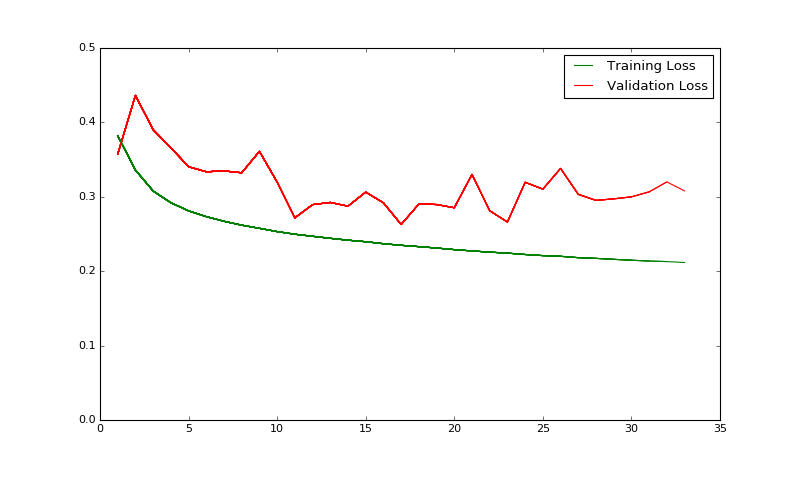

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3822

2017-03-22 19:37:42,610 : INFO : Found lower val loss for epoch 1 => 0.35734


120156/120156 [==============================] - 16s - loss: 0.3821 - val_loss: 0.3573
Epoch 2/200
120156/120156 [==============================] - 16s - loss: 0.3360 - val_loss: 0.4363
Epoch 3/200
120156/120156 [==============================] - 16s - loss: 0.3078 - val_loss: 0.3901
Epoch 4/200
120156/120156 [==============================] - 15s - loss: 0.2920 - val_loss: 0.3660
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2811

2017-03-22 19:38:46,768 : INFO : Found lower val loss for epoch 5 => 0.34037


120156/120156 [==============================] - 15s - loss: 0.2812 - val_loss: 0.3404
Epoch 6/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2733

2017-03-22 19:39:02,314 : INFO : Found lower val loss for epoch 6 => 0.33366


120156/120156 [==============================] - 15s - loss: 0.2733 - val_loss: 0.3337
Epoch 7/200
120156/120156 [==============================] - 15s - loss: 0.2671 - val_loss: 0.3348
Epoch 8/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2619

2017-03-22 19:39:34,044 : INFO : Found lower val loss for epoch 8 => 0.3323


120156/120156 [==============================] - 16s - loss: 0.2619 - val_loss: 0.3323
Epoch 9/200
120156/120156 [==============================] - 15s - loss: 0.2576 - val_loss: 0.3611
Epoch 10/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2533

2017-03-22 19:40:05,576 : INFO : Found lower val loss for epoch 10 => 0.31972


120156/120156 [==============================] - 15s - loss: 0.2532 - val_loss: 0.3197
Epoch 11/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2497

2017-03-22 19:40:21,429 : INFO : Found lower val loss for epoch 11 => 0.27169


120156/120156 [==============================] - 15s - loss: 0.2497 - val_loss: 0.2717
Epoch 12/200
120156/120156 [==============================] - 16s - loss: 0.2469 - val_loss: 0.2895
Epoch 13/200
120156/120156 [==============================] - 15s - loss: 0.2442 - val_loss: 0.2924
Epoch 14/200
120156/120156 [==============================] - 15s - loss: 0.2417 - val_loss: 0.2874
Epoch 15/200
120156/120156 [==============================] - 15s - loss: 0.2396 - val_loss: 0.3063
Epoch 16/200
120156/120156 [==============================] - 17s - loss: 0.2370 - val_loss: 0.2919
Epoch 17/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2348

2017-03-22 19:41:59,123 : INFO : Found lower val loss for epoch 17 => 0.26282


120156/120156 [==============================] - 16s - loss: 0.2348 - val_loss: 0.2628
Epoch 18/200
120156/120156 [==============================] - 17s - loss: 0.2330 - val_loss: 0.2903
Epoch 19/200
120156/120156 [==============================] - 17s - loss: 0.2311 - val_loss: 0.2896
Epoch 20/200
120156/120156 [==============================] - 17s - loss: 0.2290 - val_loss: 0.2853
Epoch 21/200
120156/120156 [==============================] - 18s - loss: 0.2272 - val_loss: 0.3301
Epoch 22/200
120156/120156 [==============================] - 18s - loss: 0.2256 - val_loss: 0.2812
Epoch 23/200
120156/120156 [==============================] - 18s - loss: 0.2243 - val_loss: 0.2661
Epoch 24/200
120156/120156 [==============================] - 18s - loss: 0.2224 - val_loss: 0.3195
Epoch 25/200
120156/120156 [==============================] - 17s - loss: 0.2210 - val_loss: 0.3103
Epoch 26/200
120156/120156 [==============================] - 18s - loss: 0.2200 - val_loss: 0.3381
Epoch 27/200


2017-03-22 19:46:51,841 : INFO : Evaluating on Training Data



Epoch 00032: early stopping
CPU times: user 4min 42s, sys: 4min 56s, total: 9min 39s
Wall time: 9min 38s


2017-03-22 19:47:41,096 : INFO : Generating Training Metrics
2017-03-22 19:47:44,072 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.676 | Top 3: 0.949 | Top 5: 0.990 | F1 Micro: 0.749 | F1 Macro: 0.641


2017-03-22 19:47:54,113 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 2.041 | Top 3: 0.865 | Top 5: 0.977 | F1 Micro: 0.537 | F1 Macro: 0.372


2017-03-22 19:47:55,034 : INFO : ***************************************************************************************
2017-03-22 19:47:55,035 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.5_stack_2_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_u-drop_0.5_w-drop_0.5_l (None, None, 500)     1402000     lstm_input_30[0][0]              
____________________________________________________________________________________________________
lstm_500_u-drop_0.5_w-drop_0.5_l (None, 500)           2002000     lstm_500_u-drop_0.5_w-drop_0.5_la
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_u-drop_0.5_w-drop_0.5_la
Total params: 3408008
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


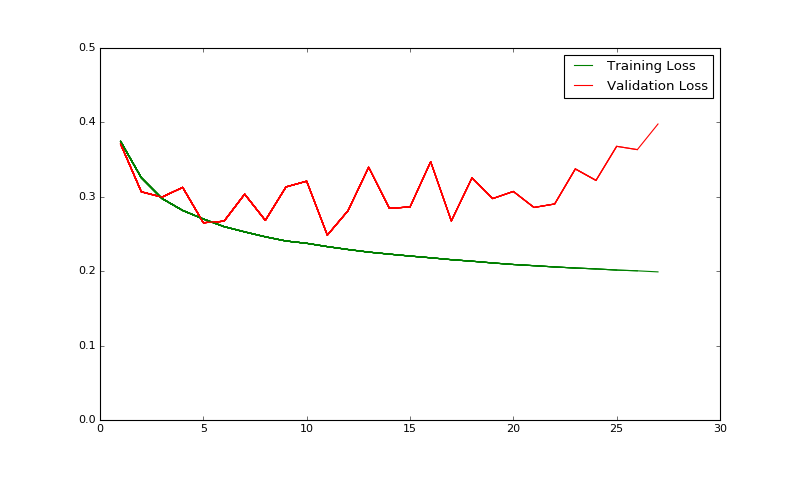

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3744

2017-03-22 19:49:38,583 : INFO : Found lower val loss for epoch 1 => 0.37072


120156/120156 [==============================] - 69s - loss: 0.3743 - val_loss: 0.3707
Epoch 2/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3257

2017-03-22 19:50:52,833 : INFO : Found lower val loss for epoch 2 => 0.30671


120156/120156 [==============================] - 74s - loss: 0.3256 - val_loss: 0.3067
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2977

2017-03-22 19:52:08,030 : INFO : Found lower val loss for epoch 3 => 0.29959


120156/120156 [==============================] - 75s - loss: 0.2977 - val_loss: 0.2996
Epoch 4/200
120156/120156 [==============================] - 76s - loss: 0.2817 - val_loss: 0.3126
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2701

2017-03-22 19:54:41,251 : INFO : Found lower val loss for epoch 5 => 0.26518


120156/120156 [==============================] - 76s - loss: 0.2702 - val_loss: 0.2652
Epoch 6/200
120156/120156 [==============================] - 75s - loss: 0.2600 - val_loss: 0.2671
Epoch 7/200
120156/120156 [==============================] - 75s - loss: 0.2528 - val_loss: 0.3036
Epoch 8/200
120156/120156 [==============================] - 75s - loss: 0.2462 - val_loss: 0.2683
Epoch 9/200
120156/120156 [==============================] - 76s - loss: 0.2406 - val_loss: 0.3133
Epoch 10/200
120156/120156 [==============================] - 74s - loss: 0.2375 - val_loss: 0.3210
Epoch 11/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2330

2017-03-22 20:02:15,450 : INFO : Found lower val loss for epoch 11 => 0.24846


120156/120156 [==============================] - 76s - loss: 0.2330 - val_loss: 0.2485
Epoch 12/200
120156/120156 [==============================] - 76s - loss: 0.2292 - val_loss: 0.2813
Epoch 13/200
120156/120156 [==============================] - 75s - loss: 0.2257 - val_loss: 0.3397
Epoch 14/200
120156/120156 [==============================] - 76s - loss: 0.2229 - val_loss: 0.2846
Epoch 15/200
120156/120156 [==============================] - 75s - loss: 0.2204 - val_loss: 0.2863
Epoch 16/200
120156/120156 [==============================] - 75s - loss: 0.2180 - val_loss: 0.3472
Epoch 17/200
120156/120156 [==============================] - 75s - loss: 0.2155 - val_loss: 0.2675
Epoch 18/200
120156/120156 [==============================] - 75s - loss: 0.2134 - val_loss: 0.3255
Epoch 19/200
120156/120156 [==============================] - 75s - loss: 0.2111 - val_loss: 0.2976
Epoch 20/200
120156/120156 [==============================] - 75s - loss: 0.2090 - val_loss: 0.3072
Epoch 21/200


2017-03-22 20:22:31,800 : INFO : Evaluating on Training Data



Epoch 00026: early stopping
CPU times: user 12min 41s, sys: 20min 39s, total: 33min 20s
Wall time: 34min 33s
120156/120156 [==============================] - 15s - loss: 0.1344 - val_loss: 0.3007
Epoch 26/200
120156/120156 [==============================] - 15s - loss: 0.1318 - val_loss: 0.2927
Epoch 27/200
120156/120156 [==============================] - 15s - loss: 0.1292 - val_loss: 0.3258

2017-03-22 22:36:25,945 : INFO : Evaluating on Training Data



Epoch 00026: early stopping
CPU times: user 3min 47s, sys: 3min 21s, total: 7min 9s
Wall time: 7min 14s


2017-03-22 22:37:02,235 : INFO : Generating Training Metrics
2017-03-22 22:37:05,238 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.498 | Top 3: 0.973 | Top 5: 0.995 | F1 Micro: 0.832 | F1 Macro: 0.779


2017-03-22 22:37:13,869 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 2.001 | Top 3: 0.872 | Top 5: 0.958 | F1 Micro: 0.593 | F1 Macro: 0.482


2017-03-22 22:37:14,798 : INFO : ***************************************************************************************
2017-03-22 22:37:14,800 : INFO : lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_200_u-drop_0.5_w-drop_0.2_l (None, 200)           320800      lstm_input_38[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             1608        lstm_200_u-drop_0.5_w-drop_0.2_la
Total params: 322408
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


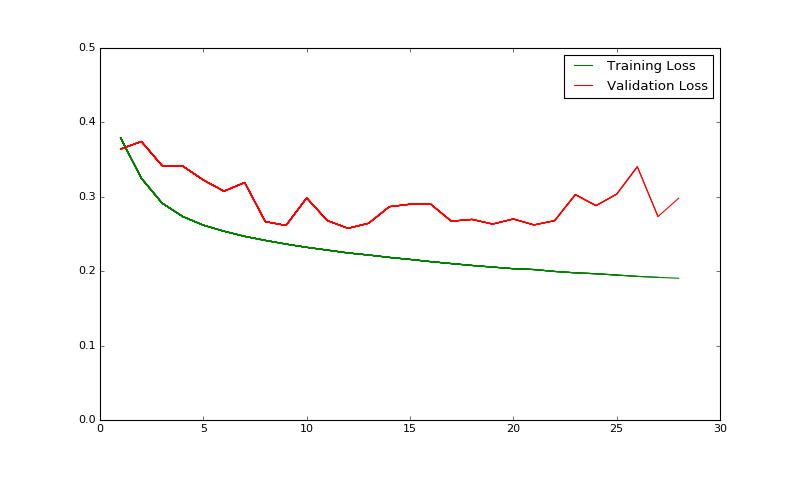

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3792

2017-03-22 22:37:51,829 : INFO : Found lower val loss for epoch 1 => 0.36422


120156/120156 [==============================] - 16s - loss: 0.3791 - val_loss: 0.3642
Epoch 2/200
120156/120156 [==============================] - 16s - loss: 0.3249 - val_loss: 0.3744
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2916

2017-03-22 22:38:25,579 : INFO : Found lower val loss for epoch 3 => 0.34198


120156/120156 [==============================] - 17s - loss: 0.2916 - val_loss: 0.3420
Epoch 4/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2735

2017-03-22 22:38:45,088 : INFO : Found lower val loss for epoch 4 => 0.34139


120156/120156 [==============================] - 19s - loss: 0.2735 - val_loss: 0.3414
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2619

2017-03-22 22:39:03,810 : INFO : Found lower val loss for epoch 5 => 0.32253


120156/120156 [==============================] - 18s - loss: 0.2619 - val_loss: 0.3225
Epoch 6/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2537

2017-03-22 22:39:23,399 : INFO : Found lower val loss for epoch 6 => 0.30755


120156/120156 [==============================] - 19s - loss: 0.2537 - val_loss: 0.3075
Epoch 7/200
120156/120156 [==============================] - 18s - loss: 0.2468 - val_loss: 0.3192
Epoch 8/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2414

2017-03-22 22:40:00,879 : INFO : Found lower val loss for epoch 8 => 0.26661


120156/120156 [==============================] - 18s - loss: 0.2414 - val_loss: 0.2666
Epoch 9/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2364

2017-03-22 22:40:20,555 : INFO : Found lower val loss for epoch 9 => 0.26151


120156/120156 [==============================] - 19s - loss: 0.2364 - val_loss: 0.2615
Epoch 10/200
120156/120156 [==============================] - 19s - loss: 0.2321 - val_loss: 0.2985
Epoch 11/200
120156/120156 [==============================] - 19s - loss: 0.2283 - val_loss: 0.2680
Epoch 12/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2245

2017-03-22 22:41:18,380 : INFO : Found lower val loss for epoch 12 => 0.25763


120156/120156 [==============================] - 18s - loss: 0.2245 - val_loss: 0.2576
Epoch 13/200
120156/120156 [==============================] - 19s - loss: 0.2217 - val_loss: 0.2645
Epoch 14/200
120156/120156 [==============================] - 18s - loss: 0.2185 - val_loss: 0.2868
Epoch 15/200
120156/120156 [==============================] - 18s - loss: 0.2158 - val_loss: 0.2900
Epoch 16/200
120156/120156 [==============================] - 19s - loss: 0.2129 - val_loss: 0.2901
Epoch 17/200
120156/120156 [==============================] - 19s - loss: 0.2102 - val_loss: 0.2672
Epoch 18/200
120156/120156 [==============================] - 19s - loss: 0.2077 - val_loss: 0.2696
Epoch 19/200
120156/120156 [==============================] - 19s - loss: 0.2055 - val_loss: 0.2634
Epoch 20/200
120156/120156 [==============================] - 19s - loss: 0.2034 - val_loss: 0.2702
Epoch 21/200
120156/120156 [==============================] - 19s - loss: 0.2022 - val_loss: 0.2622
Epoch 22/200


2017-03-22 22:46:24,463 : INFO : Evaluating on Training Data



Epoch 00027: early stopping
CPU times: user 4min 44s, sys: 4min 17s, total: 9min 1s
Wall time: 9min 8s


2017-03-22 22:47:08,332 : INFO : Generating Training Metrics
2017-03-22 22:47:11,438 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.641 | Top 3: 0.955 | Top 5: 0.991 | F1 Micro: 0.756 | F1 Macro: 0.666


2017-03-22 22:47:21,335 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 2.038 | Top 3: 0.869 | Top 5: 0.962 | F1 Micro: 0.534 | F1 Macro: 0.409


2017-03-22 22:47:22,303 : INFO : ***************************************************************************************
2017-03-22 22:47:22,304 : INFO : lstm_optimizer_rmsprop_size_200_w-drop_None_u-drop_0.2_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_200_u-drop_0.2_w-drop_None_ (None, 200)           320800      lstm_input_39[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             1608        lstm_200_u-drop_0.2_w-drop_None_l
Total params: 322408
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


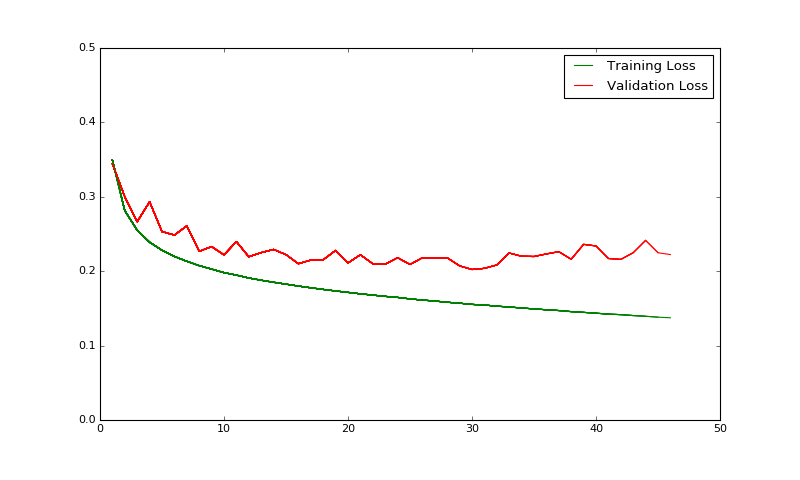

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3494

2017-03-22 22:47:50,394 : INFO : Found lower val loss for epoch 1 => 0.34435


120156/120156 [==============================] - 15s - loss: 0.3493 - val_loss: 0.3443
Epoch 2/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2814

2017-03-22 22:48:05,983 : INFO : Found lower val loss for epoch 2 => 0.30002


120156/120156 [==============================] - 15s - loss: 0.2814 - val_loss: 0.3000
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2551

2017-03-22 22:48:21,782 : INFO : Found lower val loss for epoch 3 => 0.26657


120156/120156 [==============================] - 15s - loss: 0.2551 - val_loss: 0.2666
Epoch 4/200
120156/120156 [==============================] - 17s - loss: 0.2390 - val_loss: 0.2933
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2282

2017-03-22 22:48:56,972 : INFO : Found lower val loss for epoch 5 => 0.25323


120156/120156 [==============================] - 17s - loss: 0.2282 - val_loss: 0.2532
Epoch 6/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2198

2017-03-22 22:49:14,189 : INFO : Found lower val loss for epoch 6 => 0.24854


120156/120156 [==============================] - 17s - loss: 0.2198 - val_loss: 0.2485
Epoch 7/200
120156/120156 [==============================] - 17s - loss: 0.2133 - val_loss: 0.2609
Epoch 8/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2075

2017-03-22 22:49:49,455 : INFO : Found lower val loss for epoch 8 => 0.22671


120156/120156 [==============================] - 17s - loss: 0.2075 - val_loss: 0.2267
Epoch 9/200
120156/120156 [==============================] - 17s - loss: 0.2028 - val_loss: 0.2331
Epoch 10/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1980

2017-03-22 22:50:24,528 : INFO : Found lower val loss for epoch 10 => 0.22194


120156/120156 [==============================] - 17s - loss: 0.1981 - val_loss: 0.2219
Epoch 11/200
120156/120156 [==============================] - 17s - loss: 0.1947 - val_loss: 0.2398
Epoch 12/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1909

2017-03-22 22:50:59,978 : INFO : Found lower val loss for epoch 12 => 0.21935


120156/120156 [==============================] - 17s - loss: 0.1909 - val_loss: 0.2194
Epoch 13/200
120156/120156 [==============================] - 17s - loss: 0.1879 - val_loss: 0.2250
Epoch 14/200
120156/120156 [==============================] - 18s - loss: 0.1851 - val_loss: 0.2292
Epoch 15/200
120156/120156 [==============================] - 17s - loss: 0.1826 - val_loss: 0.2222
Epoch 16/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1800

2017-03-22 22:52:11,052 : INFO : Found lower val loss for epoch 16 => 0.21005


120156/120156 [==============================] - 17s - loss: 0.1800 - val_loss: 0.2101
Epoch 17/200
120156/120156 [==============================] - 17s - loss: 0.1777 - val_loss: 0.2150
Epoch 18/200
120156/120156 [==============================] - 17s - loss: 0.1755 - val_loss: 0.2153
Epoch 19/200
120156/120156 [==============================] - 17s - loss: 0.1734 - val_loss: 0.2279
Epoch 20/200
120156/120156 [==============================] - 17s - loss: 0.1715 - val_loss: 0.2111
Epoch 21/200
120156/120156 [==============================] - 17s - loss: 0.1696 - val_loss: 0.2221
Epoch 22/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1679

2017-03-22 22:53:56,031 : INFO : Found lower val loss for epoch 22 => 0.20996
2017-03-22 22:53:56,032 : INFO : Validation Loss Reduced 10 times
2017-03-22 22:53:56,033 : INFO : Evaluating on Validation Data
2017-03-22 22:54:07,022 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.749 | Top 3: 0.921 | Top 5: 0.985 | F1 Micro: 0.666 | F1 Macro: 0.602
120156/120156 [==============================] - 29s - loss: 0.1679 - val_loss: 0.2100
Epoch 23/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1661

2017-03-22 22:54:23,726 : INFO : Found lower val loss for epoch 23 => 0.20942


120156/120156 [==============================] - 15s - loss: 0.1662 - val_loss: 0.2094
Epoch 24/200
120156/120156 [==============================] - 16s - loss: 0.1648 - val_loss: 0.2182
Epoch 25/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1628

2017-03-22 22:54:57,658 : INFO : Found lower val loss for epoch 25 => 0.209


120156/120156 [==============================] - 16s - loss: 0.1628 - val_loss: 0.2090
Epoch 26/200
120156/120156 [==============================] - 17s - loss: 0.1612 - val_loss: 0.2181
Epoch 27/200
120156/120156 [==============================] - 17s - loss: 0.1599 - val_loss: 0.2176
Epoch 28/200
120156/120156 [==============================] - 16s - loss: 0.1583 - val_loss: 0.2180
Epoch 29/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1570

2017-03-22 22:56:04,865 : INFO : Found lower val loss for epoch 29 => 0.20717


120156/120156 [==============================] - 16s - loss: 0.1570 - val_loss: 0.2072
Epoch 30/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1554

2017-03-22 22:56:21,875 : INFO : Found lower val loss for epoch 30 => 0.20227


120156/120156 [==============================] - 17s - loss: 0.1554 - val_loss: 0.2023
Epoch 31/200
120156/120156 [==============================] - 17s - loss: 0.1546 - val_loss: 0.2038
Epoch 32/200
120156/120156 [==============================] - 17s - loss: 0.1530 - val_loss: 0.2084
Epoch 33/200
120156/120156 [==============================] - 16s - loss: 0.1519 - val_loss: 0.2245
Epoch 34/200
120156/120156 [==============================] - 16s - loss: 0.1505 - val_loss: 0.2201
Epoch 35/200
120156/120156 [==============================] - 16s - loss: 0.1493 - val_loss: 0.2197
Epoch 36/200
120156/120156 [==============================] - 16s - loss: 0.1482 - val_loss: 0.2232
Epoch 37/200
120156/120156 [==============================] - 17s - loss: 0.1471 - val_loss: 0.2262
Epoch 38/200
120156/120156 [==============================] - 16s - loss: 0.1457 - val_loss: 0.2160
Epoch 39/200
120156/120156 [==============================] - 16s - loss: 0.1447 - val_loss: 0.2361
Epoch 40/200


2017-03-22 23:00:53,125 : INFO : Evaluating on Training Data



Epoch 00045: early stopping
CPU times: user 7min, sys: 6min 25s, total: 13min 25s
Wall time: 13min 29s


2017-03-22 23:01:31,691 : INFO : Generating Training Metrics
2017-03-22 23:01:34,738 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.481 | Top 3: 0.975 | Top 5: 0.996 | F1 Micro: 0.840 | F1 Macro: 0.785


2017-03-22 23:01:44,325 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.686 | Top 3: 0.933 | Top 5: 0.987 | F1 Micro: 0.683 | F1 Macro: 0.606


2017-03-22 23:01:45,260 : INFO : ***************************************************************************************
2017-03-22 23:01:45,262 : INFO : lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_None_stack_2_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_200_u-drop_None_w-drop_0.2_ (None, None, 200)     320800      lstm_input_40[0][0]              
____________________________________________________________________________________________________
lstm_200_u-drop_None_w-drop_0.2_ (None, 200)           320800      lstm_200_u-drop_None_w-drop_0.2_l
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             1608        lstm_200_u-drop_None_w-drop_0.2_l
Total params: 643208
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


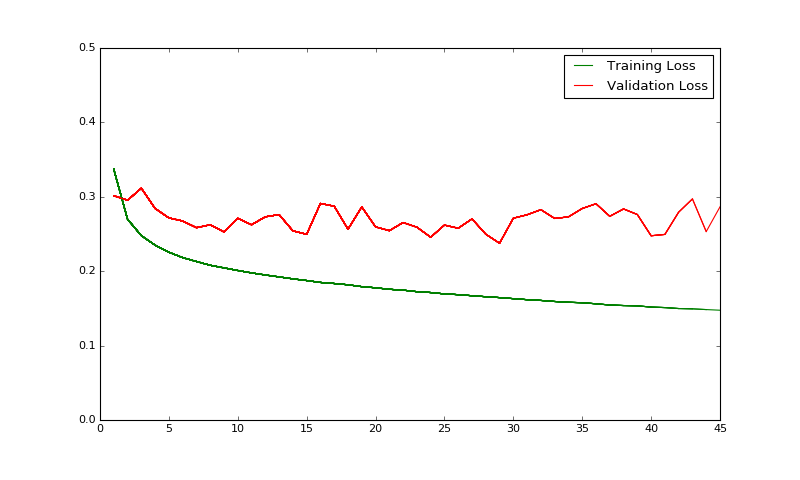

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3372

2017-03-22 23:02:47,690 : INFO : Found lower val loss for epoch 1 => 0.30142


120156/120156 [==============================] - 28s - loss: 0.3370 - val_loss: 0.3014
Epoch 2/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2699

2017-03-22 23:03:18,059 : INFO : Found lower val loss for epoch 2 => 0.29539


120156/120156 [==============================] - 30s - loss: 0.2698 - val_loss: 0.2954
Epoch 3/200
120156/120156 [==============================] - 33s - loss: 0.2478 - val_loss: 0.3115
Epoch 4/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2350

2017-03-22 23:04:23,812 : INFO : Found lower val loss for epoch 4 => 0.28431


120156/120156 [==============================] - 32s - loss: 0.2350 - val_loss: 0.2843
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2255

2017-03-22 23:04:55,831 : INFO : Found lower val loss for epoch 5 => 0.27163


120156/120156 [==============================] - 32s - loss: 0.2255 - val_loss: 0.2716
Epoch 6/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2182

2017-03-22 23:05:28,789 : INFO : Found lower val loss for epoch 6 => 0.26746


120156/120156 [==============================] - 32s - loss: 0.2182 - val_loss: 0.2675
Epoch 7/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2130

2017-03-22 23:06:02,020 : INFO : Found lower val loss for epoch 7 => 0.2585


120156/120156 [==============================] - 33s - loss: 0.2130 - val_loss: 0.2585
Epoch 8/200
120156/120156 [==============================] - 32s - loss: 0.2080 - val_loss: 0.2624
Epoch 9/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2045

2017-03-22 23:07:06,910 : INFO : Found lower val loss for epoch 9 => 0.25274


120156/120156 [==============================] - 32s - loss: 0.2045 - val_loss: 0.2527
Epoch 10/200
120156/120156 [==============================] - 33s - loss: 0.2010 - val_loss: 0.2711
Epoch 11/200
120156/120156 [==============================] - 33s - loss: 0.1977 - val_loss: 0.2624
Epoch 12/200
120156/120156 [==============================] - 32s - loss: 0.1949 - val_loss: 0.2731
Epoch 13/200
120156/120156 [==============================] - 33s - loss: 0.1923 - val_loss: 0.2761
Epoch 14/200
120156/120156 [==============================] - 32s - loss: 0.1897 - val_loss: 0.2542
Epoch 15/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1875

2017-03-22 23:10:23,965 : INFO : Found lower val loss for epoch 15 => 0.2496


120156/120156 [==============================] - 32s - loss: 0.1874 - val_loss: 0.2496
Epoch 16/200
120156/120156 [==============================] - 32s - loss: 0.1849 - val_loss: 0.2910
Epoch 17/200
120156/120156 [==============================] - 32s - loss: 0.1835 - val_loss: 0.2874
Epoch 18/200
120156/120156 [==============================] - 33s - loss: 0.1817 - val_loss: 0.2565
Epoch 19/200
120156/120156 [==============================] - 32s - loss: 0.1792 - val_loss: 0.2864
Epoch 20/200
120156/120156 [==============================] - 34s - loss: 0.1777 - val_loss: 0.2596
Epoch 21/200
120156/120156 [==============================] - 33s - loss: 0.1757 - val_loss: 0.2545
Epoch 22/200
120156/120156 [==============================] - 33s - loss: 0.1746 - val_loss: 0.2654
Epoch 23/200
120156/120156 [==============================] - 33s - loss: 0.1725 - val_loss: 0.2592
Epoch 24/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1714

2017-03-22 23:15:22,585 : INFO : Found lower val loss for epoch 24 => 0.24567


120156/120156 [==============================] - 32s - loss: 0.1713 - val_loss: 0.2457
Epoch 25/200
120156/120156 [==============================] - 32s - loss: 0.1695 - val_loss: 0.2620
Epoch 26/200
120156/120156 [==============================] - 32s - loss: 0.1685 - val_loss: 0.2578
Epoch 27/200
120156/120156 [==============================] - 32s - loss: 0.1670 - val_loss: 0.2703
Epoch 28/200
120156/120156 [==============================] - 33s - loss: 0.1657 - val_loss: 0.2497
Epoch 29/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1644

2017-03-22 23:18:05,734 : INFO : Found lower val loss for epoch 29 => 0.23757
2017-03-22 23:18:05,735 : INFO : Validation Loss Reduced 10 times
2017-03-22 23:18:05,736 : INFO : Evaluating on Validation Data
2017-03-22 23:18:27,726 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.848 | Top 3: 0.903 | Top 5: 0.977 | F1 Micro: 0.633 | F1 Macro: 0.527
120156/120156 [==============================] - 55s - loss: 0.1645 - val_loss: 0.2376
Epoch 30/200
120156/120156 [==============================] - 30s - loss: 0.1631 - val_loss: 0.2712
Epoch 31/200
120156/120156 [==============================] - 33s - loss: 0.1617 - val_loss: 0.2759
Epoch 32/200
120156/120156 [==============================] - 32s - loss: 0.1607 - val_loss: 0.2827
Epoch 33/200
120156/120156 [==============================] - 33s - loss: 0.1593 - val_loss: 0.2709
Epoch 34/200
120156/120156 [==============================] - 33s - loss: 0.1582 - val_loss: 0.2730
Epoch 35/200
120156/120156 [==============================] - 34s - loss: 0.1576 - val_loss: 0.2843
Epoch 36/200
120156/120156 [==============================] - 32s - loss: 0.1562 - val_loss: 0.2907
Epoch 37/200
120156/120156 [==============================] - 33s - loss: 0.1546 - val_loss: 0.2738
Epoch

2017-03-22 23:27:17,448 : INFO : Evaluating on Training Data



Epoch 00044: early stopping
CPU times: user 12min 24s, sys: 12min 34s, total: 24min 58s
Wall time: 25min 30s


2017-03-22 23:28:29,941 : INFO : Generating Training Metrics
2017-03-22 23:28:33,031 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.496 | Top 3: 0.974 | Top 5: 0.996 | F1 Micro: 0.827 | F1 Macro: 0.768


2017-03-22 23:28:50,980 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.848 | Top 3: 0.903 | Top 5: 0.977 | F1 Micro: 0.633 | F1 Macro: 0.527


2017-03-22 23:28:51,941 : INFO : ***************************************************************************************
2017-03-22 23:28:51,943 : INFO : lstm_optimizer_rmsprop_size_200_w-drop_None_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_200_u-drop_0.5_w-drop_None_ (None, 200)           320800      lstm_input_41[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             1608        lstm_200_u-drop_0.5_w-drop_None_l
Total params: 322408
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


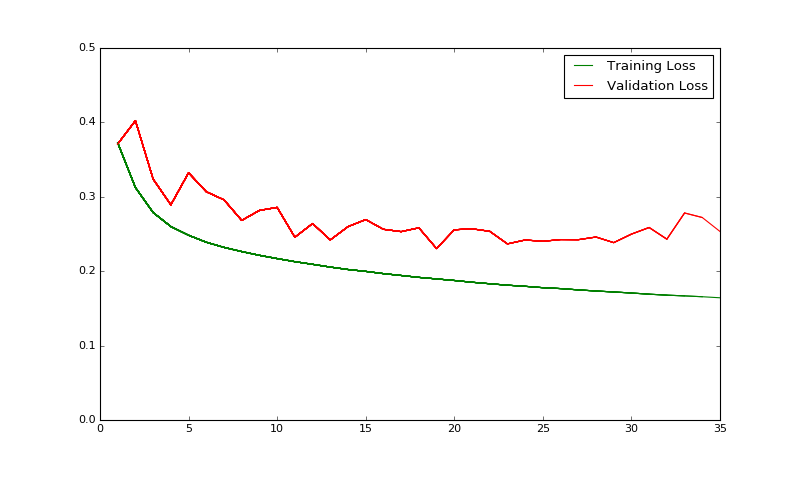

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3727

2017-03-22 23:29:25,330 : INFO : Found lower val loss for epoch 1 => 0.37104


120156/120156 [==============================] - 15s - loss: 0.3725 - val_loss: 0.3710
Epoch 2/200
120156/120156 [==============================] - 15s - loss: 0.3124 - val_loss: 0.4023
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2789

2017-03-22 23:29:55,773 : INFO : Found lower val loss for epoch 3 => 0.32378


120156/120156 [==============================] - 15s - loss: 0.2788 - val_loss: 0.3238
Epoch 4/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2601

2017-03-22 23:30:11,820 : INFO : Found lower val loss for epoch 4 => 0.28921


120156/120156 [==============================] - 16s - loss: 0.2600 - val_loss: 0.2892
Epoch 5/200
120156/120156 [==============================] - 16s - loss: 0.2483 - val_loss: 0.3323
Epoch 6/200
120156/120156 [==============================] - 17s - loss: 0.2389 - val_loss: 0.3068
Epoch 7/200
120156/120156 [==============================] - 17s - loss: 0.2320 - val_loss: 0.2959
Epoch 8/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2264

2017-03-22 23:31:20,324 : INFO : Found lower val loss for epoch 8 => 0.26829


120156/120156 [==============================] - 16s - loss: 0.2264 - val_loss: 0.2683
Epoch 9/200
120156/120156 [==============================] - 17s - loss: 0.2213 - val_loss: 0.2817
Epoch 10/200
120156/120156 [==============================] - 17s - loss: 0.2169 - val_loss: 0.2858
Epoch 11/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2128

2017-03-22 23:32:13,326 : INFO : Found lower val loss for epoch 11 => 0.24565


120156/120156 [==============================] - 17s - loss: 0.2128 - val_loss: 0.2457
Epoch 12/200
120156/120156 [==============================] - 17s - loss: 0.2092 - val_loss: 0.2640
Epoch 13/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2055

2017-03-22 23:32:47,279 : INFO : Found lower val loss for epoch 13 => 0.24206


120156/120156 [==============================] - 16s - loss: 0.2055 - val_loss: 0.2421
Epoch 14/200
120156/120156 [==============================] - 17s - loss: 0.2023 - val_loss: 0.2599
Epoch 15/200
120156/120156 [==============================] - 17s - loss: 0.1998 - val_loss: 0.2694
Epoch 16/200
120156/120156 [==============================] - 17s - loss: 0.1967 - val_loss: 0.2563
Epoch 17/200
120156/120156 [==============================] - 17s - loss: 0.1942 - val_loss: 0.2532
Epoch 18/200
120156/120156 [==============================] - 17s - loss: 0.1917 - val_loss: 0.2583
Epoch 19/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1896

2017-03-22 23:34:30,730 : INFO : Found lower val loss for epoch 19 => 0.23043


120156/120156 [==============================] - 17s - loss: 0.1896 - val_loss: 0.2304
Epoch 20/200
120156/120156 [==============================] - 17s - loss: 0.1875 - val_loss: 0.2557
Epoch 21/200
120156/120156 [==============================] - 17s - loss: 0.1852 - val_loss: 0.2570
Epoch 22/200
120156/120156 [==============================] - 16s - loss: 0.1831 - val_loss: 0.2536
Epoch 23/200
120156/120156 [==============================] - 16s - loss: 0.1812 - val_loss: 0.2367
Epoch 24/200
120156/120156 [==============================] - 17s - loss: 0.1797 - val_loss: 0.2419
Epoch 25/200
120156/120156 [==============================] - 17s - loss: 0.1778 - val_loss: 0.2402
Epoch 26/200
120156/120156 [==============================] - 17s - loss: 0.1766 - val_loss: 0.2425
Epoch 27/200
120156/120156 [==============================] - 17s - loss: 0.1749 - val_loss: 0.2424
Epoch 28/200
120156/120156 [==============================] - 17s - loss: 0.1734 - val_loss: 0.2459
Epoch 29/200


2017-03-22 23:39:05,287 : INFO : Evaluating on Training Data



Epoch 00034: early stopping
CPU times: user 5min 20s, sys: 4min 48s, total: 10min 9s
Wall time: 10min 12s


2017-03-22 23:39:45,163 : INFO : Generating Training Metrics
2017-03-22 23:39:48,192 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.569 | Top 3: 0.964 | Top 5: 0.993 | F1 Micro: 0.797 | F1 Macro: 0.718


2017-03-22 23:39:57,645 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.878 | Top 3: 0.895 | Top 5: 0.973 | F1 Micro: 0.631 | F1 Macro: 0.522


2017-03-22 23:39:58,578 : INFO : ***************************************************************************************
2017-03-22 23:39:58,580 : INFO : lstm_optimizer_rmsprop_size_200_w-drop_0.5_u-drop_None_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_200_u-drop_None_w-drop_0.5_ (None, 200)           320800      lstm_input_42[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             1608        lstm_200_u-drop_None_w-drop_0.5_l
Total params: 322408
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


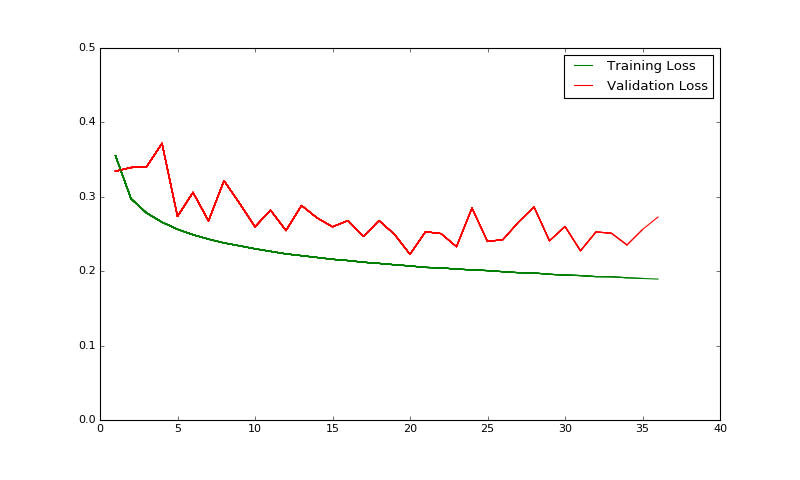

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3554

2017-03-22 23:40:26,081 : INFO : Found lower val loss for epoch 1 => 0.33438


120156/120156 [==============================] - 14s - loss: 0.3552 - val_loss: 0.3344
Epoch 2/200
120156/120156 [==============================] - 14s - loss: 0.2975 - val_loss: 0.3394
Epoch 3/200
120156/120156 [==============================] - 14s - loss: 0.2783 - val_loss: 0.3401
Epoch 4/200
120156/120156 [==============================] - 15s - loss: 0.2659 - val_loss: 0.3718
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2563

2017-03-22 23:41:26,190 : INFO : Found lower val loss for epoch 5 => 0.27363


120156/120156 [==============================] - 16s - loss: 0.2563 - val_loss: 0.2736
Epoch 6/200
120156/120156 [==============================] - 17s - loss: 0.2490 - val_loss: 0.3059
Epoch 7/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2431

2017-03-22 23:41:59,804 : INFO : Found lower val loss for epoch 7 => 0.26757


120156/120156 [==============================] - 16s - loss: 0.2431 - val_loss: 0.2676
Epoch 8/200
120156/120156 [==============================] - 16s - loss: 0.2380 - val_loss: 0.3217
Epoch 9/200
120156/120156 [==============================] - 16s - loss: 0.2341 - val_loss: 0.2913
Epoch 10/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2301

2017-03-22 23:42:49,250 : INFO : Found lower val loss for epoch 10 => 0.2597


120156/120156 [==============================] - 16s - loss: 0.2301 - val_loss: 0.2597
Epoch 11/200
120156/120156 [==============================] - 16s - loss: 0.2267 - val_loss: 0.2821
Epoch 12/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2233

2017-03-22 23:43:22,070 : INFO : Found lower val loss for epoch 12 => 0.25461


120156/120156 [==============================] - 16s - loss: 0.2233 - val_loss: 0.2546
Epoch 13/200
120156/120156 [==============================] - 17s - loss: 0.2209 - val_loss: 0.2883
Epoch 14/200
120156/120156 [==============================] - 16s - loss: 0.2185 - val_loss: 0.2717
Epoch 15/200
120156/120156 [==============================] - 17s - loss: 0.2160 - val_loss: 0.2597
Epoch 16/200
120156/120156 [==============================] - 16s - loss: 0.2143 - val_loss: 0.2680
Epoch 17/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2121

2017-03-22 23:44:46,637 : INFO : Found lower val loss for epoch 17 => 0.24681


120156/120156 [==============================] - 16s - loss: 0.2120 - val_loss: 0.2468
Epoch 18/200
120156/120156 [==============================] - 17s - loss: 0.2105 - val_loss: 0.2680
Epoch 19/200
120156/120156 [==============================] - 17s - loss: 0.2087 - val_loss: 0.2495
Epoch 20/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2071

2017-03-22 23:45:38,481 : INFO : Found lower val loss for epoch 20 => 0.2227


120156/120156 [==============================] - 17s - loss: 0.2071 - val_loss: 0.2227
Epoch 21/200
120156/120156 [==============================] - 16s - loss: 0.2051 - val_loss: 0.2530
Epoch 22/200
120156/120156 [==============================] - 17s - loss: 0.2045 - val_loss: 0.2506
Epoch 23/200
120156/120156 [==============================] - 16s - loss: 0.2028 - val_loss: 0.2330
Epoch 24/200
120156/120156 [==============================] - 16s - loss: 0.2018 - val_loss: 0.2849
Epoch 25/200
120156/120156 [==============================] - 16s - loss: 0.2008 - val_loss: 0.2399
Epoch 26/200
120156/120156 [==============================] - 16s - loss: 0.1993 - val_loss: 0.2425
Epoch 27/200
120156/120156 [==============================] - 16s - loss: 0.1980 - val_loss: 0.2660
Epoch 28/200
120156/120156 [==============================] - 16s - loss: 0.1976 - val_loss: 0.2864
Epoch 29/200
120156/120156 [==============================] - 16s - loss: 0.1958 - val_loss: 0.2409
Epoch 30/200


2017-03-22 23:50:07,845 : INFO : Evaluating on Training Data



Epoch 00035: early stopping
CPU times: user 5min 17s, sys: 4min 45s, total: 10min 3s
Wall time: 10min 8s


2017-03-22 23:50:54,017 : INFO : Generating Training Metrics
2017-03-22 23:50:57,245 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.631 | Top 3: 0.954 | Top 5: 0.991 | F1 Micro: 0.773 | F1 Macro: 0.678


2017-03-22 23:51:12,658 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.790 | Top 3: 0.921 | Top 5: 0.983 | F1 Micro: 0.627 | F1 Macro: 0.491


2017-03-22 23:51:13,634 : INFO : ***************************************************************************************
2017-03-22 23:51:13,636 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.2_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_u-drop_0.5_w-drop_0.2_l (None, 500)           1402000     lstm_input_43[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_u-drop_0.5_w-drop_0.2_la
Total params: 1406008
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


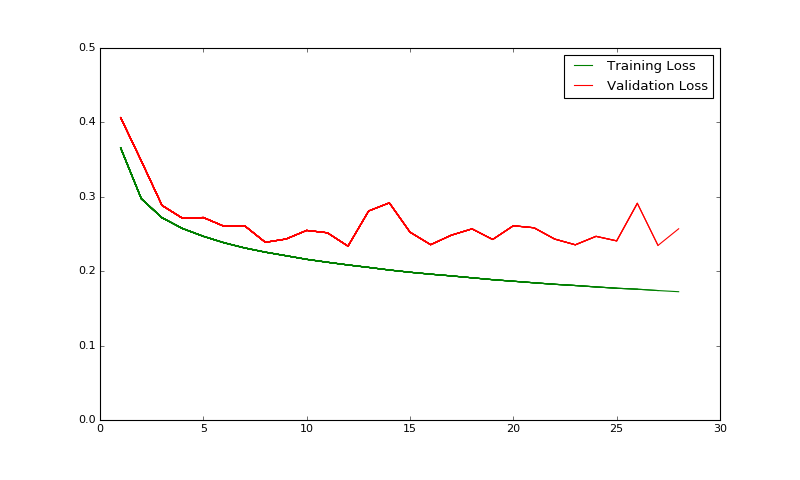

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3658

2017-03-22 23:52:23,791 : INFO : Found lower val loss for epoch 1 => 0.40635


120156/120156 [==============================] - 49s - loss: 0.3656 - val_loss: 0.4064
Epoch 2/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2974

2017-03-22 23:53:13,745 : INFO : Found lower val loss for epoch 2 => 0.34815


120156/120156 [==============================] - 49s - loss: 0.2974 - val_loss: 0.3482
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2719

2017-03-22 23:54:04,155 : INFO : Found lower val loss for epoch 3 => 0.28845


120156/120156 [==============================] - 50s - loss: 0.2719 - val_loss: 0.2884
Epoch 4/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2573

2017-03-22 23:54:51,663 : INFO : Found lower val loss for epoch 4 => 0.27102


120156/120156 [==============================] - 47s - loss: 0.2573 - val_loss: 0.2710
Epoch 5/200
120156/120156 [==============================] - 34s - loss: 0.2469 - val_loss: 0.2722
Epoch 6/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2382

2017-03-22 23:56:11,693 : INFO : Found lower val loss for epoch 6 => 0.26039


120156/120156 [==============================] - 45s - loss: 0.2382 - val_loss: 0.2604
Epoch 7/200
120156/120156 [==============================] - 50s - loss: 0.2312 - val_loss: 0.2610
Epoch 8/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2256

2017-03-22 23:57:54,516 : INFO : Found lower val loss for epoch 8 => 0.23885


120156/120156 [==============================] - 52s - loss: 0.2256 - val_loss: 0.2388
Epoch 9/200
120156/120156 [==============================] - 50s - loss: 0.2208 - val_loss: 0.2432
Epoch 10/200
120156/120156 [==============================] - 50s - loss: 0.2160 - val_loss: 0.2548
Epoch 11/200
120156/120156 [==============================] - 50s - loss: 0.2120 - val_loss: 0.2517
Epoch 12/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2084

2017-03-23 00:01:17,860 : INFO : Found lower val loss for epoch 12 => 0.23367


120156/120156 [==============================] - 52s - loss: 0.2084 - val_loss: 0.2337
Epoch 13/200
120156/120156 [==============================] - 51s - loss: 0.2051 - val_loss: 0.2810
Epoch 14/200
120156/120156 [==============================] - 49s - loss: 0.2016 - val_loss: 0.2919
Epoch 15/200
120156/120156 [==============================] - 37s - loss: 0.1986 - val_loss: 0.2525
Epoch 16/200
120156/120156 [==============================] - 39s - loss: 0.1960 - val_loss: 0.2356
Epoch 17/200
120156/120156 [==============================] - 51s - loss: 0.1937 - val_loss: 0.2484
Epoch 18/200
120156/120156 [==============================] - 50s - loss: 0.1911 - val_loss: 0.2569
Epoch 19/200
120156/120156 [==============================] - 50s - loss: 0.1886 - val_loss: 0.2427
Epoch 20/200
120156/120156 [==============================] - 45s - loss: 0.1865 - val_loss: 0.2611
Epoch 21/200
120156/120156 [==============================] - 34s - loss: 0.1844 - val_loss: 0.2584
Epoch 22/200


2017-03-23 00:13:16,310 : INFO : Evaluating on Training Data



Epoch 00027: early stopping
CPU times: user 8min 21s, sys: 13min 12s, total: 21min 33s
Wall time: 22min


2017-03-23 00:14:37,929 : INFO : Generating Training Metrics
2017-03-23 00:14:40,945 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.568 | Top 3: 0.964 | Top 5: 0.993 | F1 Micro: 0.798 | F1 Macro: 0.714


2017-03-23 00:15:00,310 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.889 | Top 3: 0.895 | Top 5: 0.973 | F1 Micro: 0.608 | F1 Macro: 0.474


2017-03-23 00:15:01,259 : INFO : ***************************************************************************************
2017-03-23 00:15:01,261 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.2_u-drop_None_stack_2_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_u-drop_None_w-drop_0.2_ (None, None, 500)     1402000     lstm_input_44[0][0]              
____________________________________________________________________________________________________
lstm_500_u-drop_None_w-drop_0.2_ (None, 500)           2002000     lstm_500_u-drop_None_w-drop_0.2_l
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_u-drop_None_w-drop_0.2_l
Total params: 3408008
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


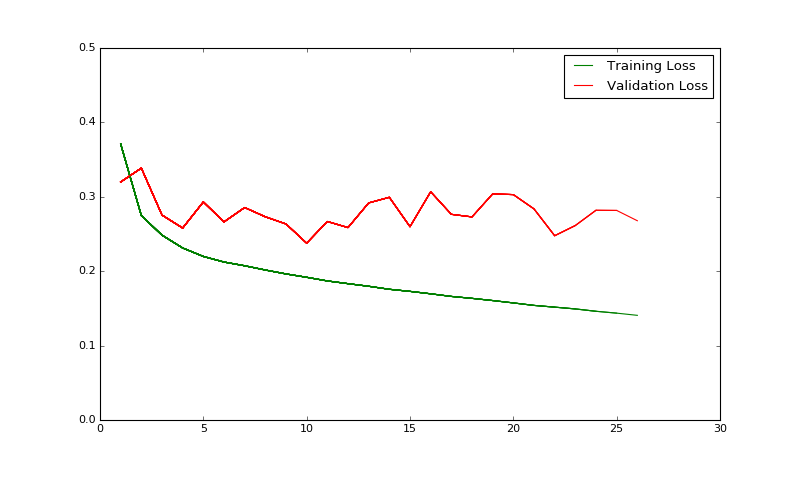

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3712

2017-03-23 00:16:42,440 : INFO : Found lower val loss for epoch 1 => 0.31989


120156/120156 [==============================] - 71s - loss: 0.3710 - val_loss: 0.3199
Epoch 2/200
120156/120156 [==============================] - 71s - loss: 0.2748 - val_loss: 0.3386
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2485

2017-03-23 00:19:02,694 : INFO : Found lower val loss for epoch 3 => 0.27544


120156/120156 [==============================] - 69s - loss: 0.2484 - val_loss: 0.2754
Epoch 4/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2312

2017-03-23 00:20:13,575 : INFO : Found lower val loss for epoch 4 => 0.25801


120156/120156 [==============================] - 70s - loss: 0.2312 - val_loss: 0.2580
Epoch 5/200
120156/120156 [==============================] - 68s - loss: 0.2198 - val_loss: 0.2931
Epoch 6/200
120156/120156 [==============================] - 70s - loss: 0.2123 - val_loss: 0.2663
Epoch 7/200
120156/120156 [==============================] - 69s - loss: 0.2073 - val_loss: 0.2856
Epoch 8/200
120156/120156 [==============================] - 69s - loss: 0.2016 - val_loss: 0.2731
Epoch 9/200
120156/120156 [==============================] - 71s - loss: 0.1963 - val_loss: 0.2635
Epoch 10/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1919

2017-03-23 00:27:12,244 : INFO : Found lower val loss for epoch 10 => 0.23768


120156/120156 [==============================] - 69s - loss: 0.1918 - val_loss: 0.2377
Epoch 11/200
120156/120156 [==============================] - 70s - loss: 0.1869 - val_loss: 0.2668
Epoch 12/200
120156/120156 [==============================] - 71s - loss: 0.1833 - val_loss: 0.2586
Epoch 13/200
120156/120156 [==============================] - 67s - loss: 0.1797 - val_loss: 0.2918
Epoch 14/200
120156/120156 [==============================] - 72s - loss: 0.1757 - val_loss: 0.2993
Epoch 15/200
120156/120156 [==============================] - 71s - loss: 0.1729 - val_loss: 0.2598
Epoch 16/200
120156/120156 [==============================] - 69s - loss: 0.1696 - val_loss: 0.3068
Epoch 17/200
120156/120156 [==============================] - 70s - loss: 0.1661 - val_loss: 0.2764
Epoch 18/200
120156/120156 [==============================] - 70s - loss: 0.1635 - val_loss: 0.2730
Epoch 19/200
120156/120156 [==============================] - 69s - loss: 0.1605 - val_loss: 0.3039
Epoch 20/200


2017-03-23 00:45:58,854 : INFO : Evaluating on Training Data



Epoch 00025: early stopping
CPU times: user 11min 54s, sys: 18min 5s, total: 29min 59s
Wall time: 30min 54s


2017-03-23 00:49:31,298 : INFO : Generating Training Metrics
2017-03-23 00:49:34,284 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.477 | Top 3: 0.978 | Top 5: 0.997 | F1 Micro: 0.836 | F1 Macro: 0.791


2017-03-23 00:50:11,278 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.855 | Top 3: 0.902 | Top 5: 0.973 | F1 Micro: 0.638 | F1 Macro: 0.533


2017-03-23 00:50:12,214 : INFO : ***************************************************************************************
2017-03-23 00:50:12,216 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_None_u-drop_0.2_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_u-drop_0.2_w-drop_None_ (None, 500)           1402000     lstm_input_45[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_u-drop_0.2_w-drop_None_l
Total params: 1406008
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


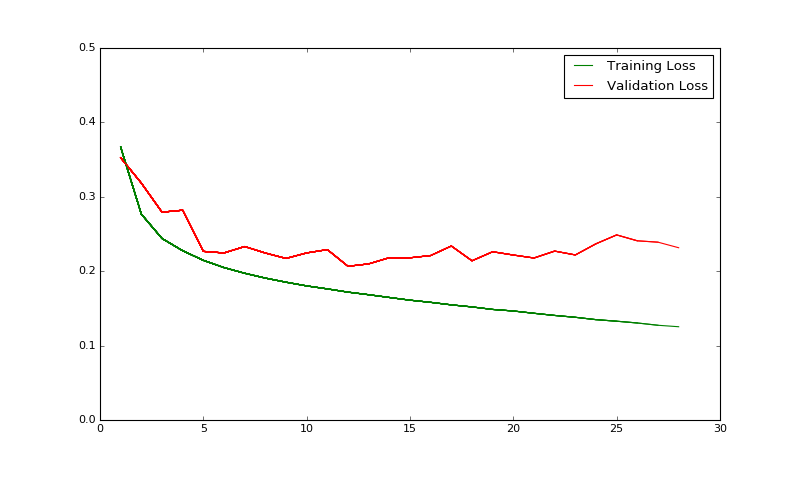

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3669

2017-03-23 00:51:06,359 : INFO : Found lower val loss for epoch 1 => 0.3525


120156/120156 [==============================] - 35s - loss: 0.3668 - val_loss: 0.3525
Epoch 2/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2768

2017-03-23 00:51:43,701 : INFO : Found lower val loss for epoch 2 => 0.31845


120156/120156 [==============================] - 37s - loss: 0.2767 - val_loss: 0.3184
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2441

2017-03-23 00:52:20,334 : INFO : Found lower val loss for epoch 3 => 0.27936


120156/120156 [==============================] - 36s - loss: 0.2440 - val_loss: 0.2794
Epoch 4/200
120156/120156 [==============================] - 36s - loss: 0.2275 - val_loss: 0.2820
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2146

2017-03-23 00:53:33,790 : INFO : Found lower val loss for epoch 5 => 0.22664


120156/120156 [==============================] - 37s - loss: 0.2146 - val_loss: 0.2266
Epoch 6/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2049

2017-03-23 00:54:09,488 : INFO : Found lower val loss for epoch 6 => 0.22453


120156/120156 [==============================] - 35s - loss: 0.2049 - val_loss: 0.2245
Epoch 7/200
120156/120156 [==============================] - 35s - loss: 0.1972 - val_loss: 0.2332
Epoch 8/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1907

2017-03-23 00:55:20,919 : INFO : Found lower val loss for epoch 8 => 0.22444


120156/120156 [==============================] - 35s - loss: 0.1907 - val_loss: 0.2244
Epoch 9/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1852

2017-03-23 00:55:57,528 : INFO : Found lower val loss for epoch 9 => 0.21716


120156/120156 [==============================] - 36s - loss: 0.1852 - val_loss: 0.2172
Epoch 10/200
120156/120156 [==============================] - 34s - loss: 0.1802 - val_loss: 0.2246
Epoch 11/200
120156/120156 [==============================] - 36s - loss: 0.1762 - val_loss: 0.2290
Epoch 12/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1718

2017-03-23 00:57:44,766 : INFO : Found lower val loss for epoch 12 => 0.20662


120156/120156 [==============================] - 36s - loss: 0.1719 - val_loss: 0.2066
Epoch 13/200
120156/120156 [==============================] - 45s - loss: 0.1684 - val_loss: 0.2098
Epoch 14/200
120156/120156 [==============================] - 51s - loss: 0.1647 - val_loss: 0.2182
Epoch 15/200
120156/120156 [==============================] - 49s - loss: 0.1611 - val_loss: 0.2180
Epoch 16/200
120156/120156 [==============================] - 49s - loss: 0.1581 - val_loss: 0.2210
Epoch 17/200
120156/120156 [==============================] - 41s - loss: 0.1548 - val_loss: 0.2339
Epoch 18/200
120156/120156 [==============================] - 35s - loss: 0.1520 - val_loss: 0.2140
Epoch 19/200
120156/120156 [==============================] - 36s - loss: 0.1486 - val_loss: 0.2262
Epoch 20/200
120156/120156 [==============================] - 35s - loss: 0.1465 - val_loss: 0.2217
Epoch 21/200
120156/120156 [==============================] - 35s - loss: 0.1434 - val_loss: 0.2177
Epoch 22/200


2017-03-23 01:08:20,299 : INFO : Evaluating on Training Data



Epoch 00027: early stopping
CPU times: user 7min 7s, sys: 10min 49s, total: 17min 56s
Wall time: 18min 6s


2017-03-23 01:09:41,948 : INFO : Generating Training Metrics
2017-03-23 01:09:45,040 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.431 | Top 3: 0.981 | Top 5: 0.997 | F1 Micro: 0.867 | F1 Macro: 0.821


2017-03-23 01:10:05,372 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.724 | Top 3: 0.928 | Top 5: 0.981 | F1 Micro: 0.673 | F1 Macro: 0.609


2017-03-23 01:10:06,339 : INFO : ***************************************************************************************
2017-03-23 01:10:06,340 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_None_u-drop_None_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_u-drop_None_w-drop_None (None, 500)           1402000     lstm_input_46[0][0]              
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_u-drop_None_w-drop_None_
Total params: 1406008
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


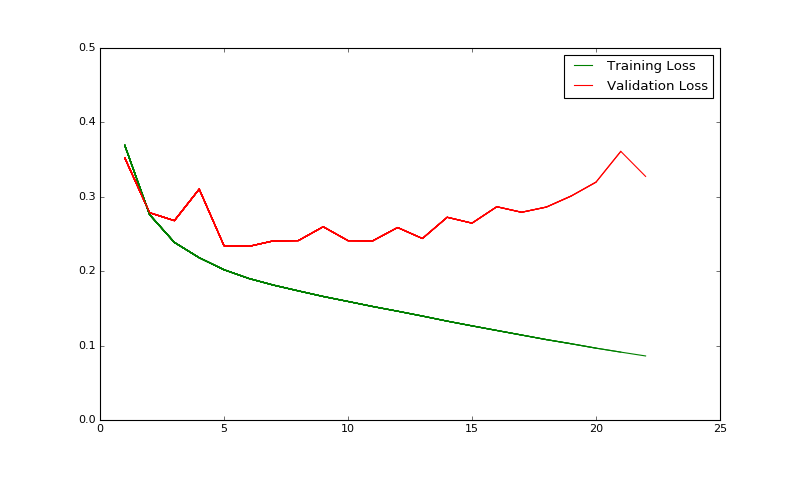

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3693

2017-03-23 01:10:53,122 : INFO : Found lower val loss for epoch 1 => 0.35219


120156/120156 [==============================] - 29s - loss: 0.3691 - val_loss: 0.3522
Epoch 2/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2760

2017-03-23 01:11:31,629 : INFO : Found lower val loss for epoch 2 => 0.2786


120156/120156 [==============================] - 38s - loss: 0.2760 - val_loss: 0.2786
Epoch 3/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2387

2017-03-23 01:12:13,414 : INFO : Found lower val loss for epoch 3 => 0.26796


120156/120156 [==============================] - 41s - loss: 0.2387 - val_loss: 0.2680
Epoch 4/200
120156/120156 [==============================] - 40s - loss: 0.2181 - val_loss: 0.3103
Epoch 5/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.2020

2017-03-23 01:13:34,155 : INFO : Found lower val loss for epoch 5 => 0.23429


120156/120156 [==============================] - 40s - loss: 0.2020 - val_loss: 0.2343
Epoch 6/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.1902

2017-03-23 01:14:13,714 : INFO : Found lower val loss for epoch 6 => 0.23335


120156/120156 [==============================] - 39s - loss: 0.1902 - val_loss: 0.2333
Epoch 7/200
120156/120156 [==============================] - 31s - loss: 0.1813 - val_loss: 0.2408
Epoch 8/200
120156/120156 [==============================] - 30s - loss: 0.1735 - val_loss: 0.2412
Epoch 9/200
120156/120156 [==============================] - 37s - loss: 0.1660 - val_loss: 0.2597
Epoch 10/200
120156/120156 [==============================] - 39s - loss: 0.1593 - val_loss: 0.2411
Epoch 11/200
120156/120156 [==============================] - 40s - loss: 0.1525 - val_loss: 0.2409
Epoch 12/200
120156/120156 [==============================] - 40s - loss: 0.1462 - val_loss: 0.2587
Epoch 13/200
120156/120156 [==============================] - 40s - loss: 0.1397 - val_loss: 0.2439
Epoch 14/200
120156/120156 [==============================] - 34s - loss: 0.1329 - val_loss: 0.2725
Epoch 15/200
120156/120156 [==============================] - 29s - loss: 0.1265 - val_loss: 0.2646
Epoch 16/200
120

2017-03-23 01:23:06,748 : INFO : Evaluating on Training Data



Epoch 00021: early stopping
CPU times: user 5min 15s, sys: 7min 41s, total: 12min 56s
Wall time: 12min 58s


2017-03-23 01:24:36,824 : INFO : Generating Training Metrics
2017-03-23 01:24:40,392 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.387 | Top 3: 0.987 | Top 5: 0.999 | F1 Micro: 0.891 | F1 Macro: 0.850


2017-03-23 01:25:06,584 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.856 | Top 3: 0.909 | Top 5: 0.976 | F1 Micro: 0.602 | F1 Macro: 0.501


2017-03-23 01:25:07,645 : INFO : ***************************************************************************************
2017-03-23 01:25:07,645 : INFO : lstm_optimizer_rmsprop_size_500_w-drop_0.5_u-drop_0.2_stack_2_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_500_u-drop_0.2_w-drop_0.5_l (None, None, 500)     1402000     lstm_input_47[0][0]              
____________________________________________________________________________________________________
lstm_500_u-drop_0.2_w-drop_0.5_l (None, 500)           2002000     lstm_500_u-drop_0.2_w-drop_0.5_la
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             4008        lstm_500_u-drop_0.2_w-drop_0.5_la
Total params: 3408008
____________________________________________________________________________________________________
Train on 120156 samples, validate on 29675 samples


<IPython.core.display.Javascript object>


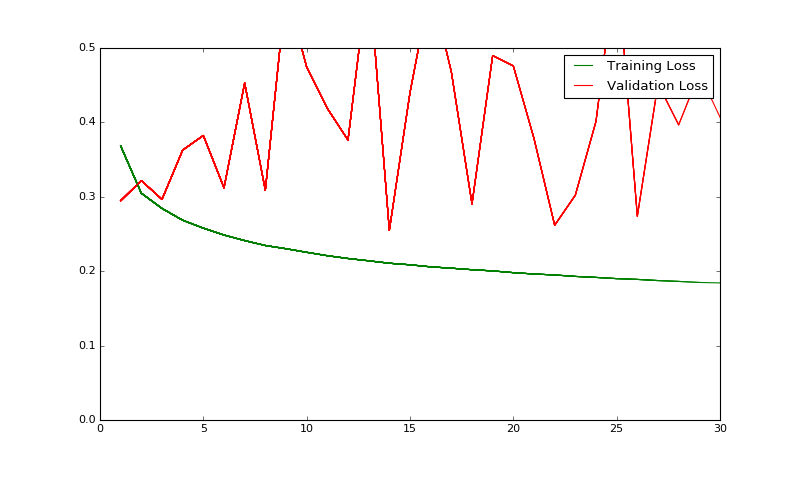

Epoch 1/200
119808/120156 [============================>.] - ETA: 0s - loss: 0.3685

2017-03-23 01:26:52,213 : INFO : Found lower val loss for epoch 1 => 0.29473


120156/120156 [==============================] - 75s - loss: 0.3683 - val_loss: 0.2947
Epoch 2/200
120156/120156 [==============================] - 76s - loss: 0.3048 - val_loss: 0.3218
Epoch 3/200
120156/120156 [==============================] - 77s - loss: 0.2843 - val_loss: 0.2965
Epoch 4/200
120156/120156 [==============================] - 75s - loss: 0.2685 - val_loss: 0.3627
Epoch 5/200
120156/120156 [==============================] - 77s - loss: 0.2579 - val_loss: 0.3824
Epoch 6/200
120156/120156 [==============================] - 76s - loss: 0.2486 - val_loss: 0.3121
Epoch 7/200
120156/120156 [==============================] - 74s - loss: 0.2411 - val_loss: 0.4529
Epoch 8/200
120156/120156 [==============================] - 76s - loss: 0.2345 - val_loss: 0.3088
Epoch 9/200
120156/120156 [==============================] - 77s - loss: 0.2302 - val_loss: 0.5791
Epoch 10/200
120156/120156 [==============================] - 76s - loss: 0.2254 - val_loss: 0.4743
Epoch 11/200
120156/1

2017-03-23 01:43:25,837 : INFO : Found lower val loss for epoch 14 => 0.25486


120156/120156 [==============================] - 75s - loss: 0.2107 - val_loss: 0.2549
Epoch 15/200
120156/120156 [==============================] - 77s - loss: 0.2086 - val_loss: 0.4400
Epoch 16/200
120156/120156 [==============================] - 76s - loss: 0.2059 - val_loss: 0.5845
Epoch 17/200
120156/120156 [==============================] - 76s - loss: 0.2040 - val_loss: 0.4680
Epoch 18/200
120156/120156 [==============================] - 77s - loss: 0.2020 - val_loss: 0.2904
Epoch 19/200
120156/120156 [==============================] - 75s - loss: 0.2004 - val_loss: 0.4898
Epoch 20/200
120156/120156 [==============================] - 76s - loss: 0.1981 - val_loss: 0.4759
Epoch 21/200
120156/120156 [==============================] - 77s - loss: 0.1962 - val_loss: 0.3783
Epoch 22/200
120156/120156 [==============================] - 76s - loss: 0.1949 - val_loss: 0.2618
Epoch 23/200
120156/120156 [==============================] - 76s - loss: 0.1930 - val_loss: 0.3022
Epoch 24/200


2017-03-23 02:03:52,176 : INFO : Evaluating on Training Data



Epoch 00029: early stopping
CPU times: user 14min 53s, sys: 22min 18s, total: 37min 11s
Wall time: 38min 41s


2017-03-23 02:06:30,715 : INFO : Generating Training Metrics
2017-03-23 02:06:33,701 : INFO : Evaluating on Validation Data using saved best weights


****** Training Metrics: Cov Err: 1.585 | Top 3: 0.961 | Top 5: 0.993 | F1 Micro: 0.789 | F1 Macro: 0.708


2017-03-23 02:07:10,391 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.942 | Top 3: 0.893 | Top 5: 0.983 | F1 Micro: 0.562 | F1 Macro: 0.400


2017-03-23 02:07:11,315 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_all_levels_3/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_2_batch_1024_nn_parameter_searches.pkl


In [ ]:
%matplotlib notebook

param_sampler = ParameterSampler({
    'lstm_output_size':lstm_output_sizes,
    'w_dropout':w_dropout_options,
    'u_dropout':u_dropout_options,
    'stack_layers':stack_layers_options,
    'conv_size':conv_size_options,
}, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

param_results_dict = {}

param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))

if load_existing_results:
    if os.path.exists(param_results_path):
        info('Loading Previous results from {}'.format(param_results_path))
        param_results_dict = pickle.load(open(param_results_path))
    else:
        info('No Previous results exist in {}'.format(param_results_path))
        
# create nn parameter search directory
if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
    os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
        
for parameters in param_sampler:
    start_time = time.time()
    lstm_output_size = parameters['lstm_output_size']
    w_dropout_do = parameters['w_dropout']
    u_dropout_do = parameters['u_dropout']
    stack_layers = parameters['stack_layers']
    conv_size = parameters['conv_size']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue
#         if first_hidden_layer_size < DOC2VEC_SIZE or second_hidden_layer_size < NN_OUTPUT_NEURONS:
#             print "skipping: {} due to 1st layer size {} < {} or 2nd layer size {} < {}".format(GLOBAL_VARS.NN_MODEL_NAME,
#                                                                                                 first_hidden_layer_size, DOC2VEC_SIZE, 
#                                                                                                 second_hidden_layer_size, NN_OUTPUT_NEURONS)
#             continue


    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size)
    model.summary()


    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()



    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    info('Evaluating on Training Data')
    yp = model.predict(X)
    yp_binary = get_binary_0_5(yp)
    #print yvp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv)
    yvp_binary = get_binary_0_5(yvp)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    time.sleep(0.2)
    

    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses
    
#         param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['last_weights'] = last_model_weights

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

if save_results:
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            loaded_param_results_dict = pickle.load(open(param_results_path))
            param_results_dict.update(loaded_param_results_dict)
            
    pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))

In [50]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.2',
 'lstm_optimizer_adam_size_300_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.3_u-drop_0.2',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.2',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.4']

In [ ]:
%xdel model
import gc
for i in range(3): gc.collect()

In [74]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))

In [52]:
    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
        